# Assignment 1 - Sentiment Analysis of Tweets on Canadian Political Landscape 

This notebook explore prediction on tweet sentiments using logistic regression. We will use sentiment values to analyze potential insights into the political sentiment of the Canadian electorate with respect to the major political parties participating in the 2015 federal election.

Three datasets are available: a classfied training set, a classfied test set, and an unclassified test set which will be used for analyzing political sentiment.

In [1]:
# import useful modules 
import pandas as pd
import re as regex
import sklearn
import requests
import numpy as np
from collections import Counter
import html
import matplotlib.pyplot as plt
from datetime import datetime
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We first load unclassfied and classified tweets, and have a look at the data. We add party columns in unclassfied dataframe which will be later used to indicate if a tweet is related to certain parties. For example, if a tweet is related to Liberal party, then its corresponding 'Liberal' value will be true.

In [2]:
#retrive unclassfied data as dataframe
unclassified_tweetsList = open('unclassified_tweets.txt','r').read().split('\n')
unclassified_tweetsList = list(filter(None, unclassified_tweetsList))
unclassified_tweetsFrame = pd.DataFrame ({
        'text': unclassified_tweetsList,
        'class': '',
        'Liberal': 'false',
        'Conservative': 'false',
        'Bloc Quebecois': 'false',
        'Democratic': 'false',
        'Green': 'false'
})

#retrive classfied data as dataframe
classified_tweetsFrame = pd.read_csv('classified_tweets.txt', usecols = ["class","id","date","query","user","text"])

In [3]:
unclassified_tweetsFrame.head()

,Bloc Quebecois,Conservative,Democratic,Green,Liberal,class,text
0,false,false,false,false,false,,﻿living the dream. #cameraman #camera #camerac...
1,false,false,false,false,false,,justin #trudeau's reasons for thanksgiving. to...
2,false,false,false,false,false,,@themadape butt…..butt…..we’re allergic to l...
3,false,false,false,false,false,,2 massive explosions at peace march in #turkey...
4,false,false,false,false,false,,#mulcair suggests there’s bad blood between hi...


In [4]:
classified_tweetsFrame.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Part 1: Data Cleaning
We clean the Twitter data to remove 'noise' and to have better prediction results.
All urls, html tags and attributes, special characters should be removed in both datasets.
Tweets are converted to lowercase.
Html characters are converted to ascii number.

In [5]:
#remove regex in tweets
def remove_by_regex(tweets, expression):
    tweets.loc[:, 'text'].replace(expression, "", inplace=True)
    return tweets

#remove urls in tweets
def remove_urls(tweets):
    return remove_by_regex(tweets, regex.compile(r"(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*?($|\s))"))

#remove html tags and attributes
def remove_html_tags(tweets):
    return remove_by_regex(tweets, regex.compile(r"<[^>]+>"))

#remove punctuations and special characters for better training data
def remove_special_characters(tweets):  
    for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#","…"]):
        tweets.loc[:, 'text'].replace(remove, " ", inplace=True)
    return tweets

#remove usernames
def remove_usernames(tweets):
        return remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

#convert tweets to lowercase
def to_lower_case(tweets):
    return tweets.apply(lambda x: x.astype(str).str.lower())

#convert html character to ascii
def convert_html_character(tweets):
    return tweets.replace({'&quot;': '34', '&amp;': '38', '&lt;' : '60', '&gt' : '62'}, regex=True)

#remove stop words
def remove_stop_words(tweets):
    for i in range(0, len(tweets)):
        tweets.loc[i,'text'] = ' '.join([word for word in tweets['text'][i].split() if word not in nltk.corpus.stopwords.words("english")])
    return tweets
    
def data_cleaning(tweetsList) :
    tweetsList = to_lower_case(remove_special_characters(convert_html_character(remove_html_tags(remove_urls(tweetsList)))))
    return tweetsList

We keep usernames in unclassfied tweets because they might contain keywords related to political parties. 
We remove all stop words in unclassfied tweets that exists in nltk english stop word collection.

In [6]:
unclassified_tweetsFrame = remove_stop_words(data_cleaning(unclassified_tweetsFrame))
unclassified_tweetsFrame.head()

,Bloc Quebecois,Conservative,Democratic,Green,Liberal,class,text
0,false,false,false,false,false,,﻿living dream cameraman camera cameraception c...
1,false,false,false,false,false,,justin trudeau reasons thanksgiving today mont...
2,false,false,false,false,false,,themadape butt butt we’re allergic latex makes...
3,false,false,false,false,false,,2 massive explosions peace march turkey 30 kil...
4,false,false,false,false,false,,mulcair suggests there’s bad blood trudeau rea...


We remove usernames in classified tweets because they should not affect sentiment value.
Stop words will be later removed using CountVectorizer(stop_words = 'english') in part 4.

In [7]:
#clean classified tweets, stop words will be later removed using CountVectorizer(stop_words = 'english')
classified_tweetsFrame = data_cleaning(remove_usernames(classified_tweetsFrame))
classified_tweetsFrame.head()

,class,id,date,query,user,text
0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,awww that s a bummer you shoulda got davi...
1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,is upset that he can t update his facebook by ...
2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,i dived many times for the ball managed to sa...
3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,my whole body feels itchy and like its on fire
4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,no it s not behaving at all i m mad why am ...


## Part 2: Exploratory Analysis

### a. Exploratory Analysis on Unclassfied Tweets

We tokenize words in unclassfied tweets because we need to iterate through them to find words related to political parties.

In [8]:
def tokenize_table(tweets, tokenizer):
    def tokenize_tweet(tweet):
        #tokenize each tweet
        tweet["tokenized_text"] = tokenizer(tweet["text"])
        return tweet

    tweets = tweets.apply(tokenize_tweet, axis=1)
    return tweets

unclassified_tweetsFrame = tokenize_table(unclassified_tweetsFrame, nltk.word_tokenize)
unclassified_tweetsFrame.head()

,Bloc Quebecois,Conservative,Democratic,Green,Liberal,class,text,tokenized_text
0,false,false,false,false,false,,﻿living dream cameraman camera cameraception c...,"[﻿living, dream, cameraman, camera, cameracept..."
1,false,false,false,false,false,,justin trudeau reasons thanksgiving today mont...,"[justin, trudeau, reasons, thanksgiving, today..."
2,false,false,false,false,false,,themadape butt butt we’re allergic latex makes...,"[themadape, butt, butt, we, ’, re, allergic, l..."
3,false,false,false,false,false,,2 massive explosions peace march turkey 30 kil...,"[2, massive, explosions, peace, march, turkey,..."
4,false,false,false,false,false,,mulcair suggests there’s bad blood trudeau rea...,"[mulcair, suggests, there, ’, s, bad, blood, t..."


We iterate through each tokenized tweet to find out if it is related to politcal parties, count the number of tweets related to each party. As stop words in unclassified dataset were already removed in part 1, we save some running time. A tweet can be related to multiple parties because it may contain multiple different keywords. 

In [9]:
tweet_parties = Counter()
parties = ["Liberal", "Conservative", "Quebecois", "Democratic", "Green"]

#check if a tweet is related to polical parties, set to true if related
for i in range(len(unclassified_tweetsFrame)):
    for word in unclassified_tweetsFrame.loc[i, 'tokenized_text']:
        if word.find('trudeau') > -1 or word.find('liberal') > -1:
            unclassified_tweetsFrame.loc[i, 'Liberal'] = 'true'
            
        if word.find('conservative') > -1 or word == 'tory' or word == 'tories' or word.find('harper') > -1:
            unclassified_tweetsFrame.loc[i, 'Conservative'] = 'true'

        if word.find('block') == -1 and word.find('bloc') > -1 or word.find('quebecois') > -1 or word.find('duceppe') > -1:
            unclassified_tweetsFrame.loc[i, 'Bloc Quebecois'] = 'true'

        if word.find('democra') > -1 or word == 'dems' or word.find('mulcair') > -1:
            unclassified_tweetsFrame.loc[i, 'Democratic'] = 'true'

        if word.find('green') > -1 or word.find('elizabethmay') > -1:
            unclassified_tweetsFrame.loc[i, 'Green'] = 'true'

#get number of tweets for each party            
tweet_parties['Liberal'] = len(unclassified_tweetsFrame[unclassified_tweetsFrame['Liberal'] == 'true'])
tweet_parties['Conservative'] = len(unclassified_tweetsFrame[unclassified_tweetsFrame['Conservative'] == 'true'])
tweet_parties['Quebecois'] = len(unclassified_tweetsFrame[unclassified_tweetsFrame['Bloc Quebecois'] == 'true'])
tweet_parties['Democratic'] = len(unclassified_tweetsFrame[unclassified_tweetsFrame['Democratic'] == 'true'])
tweet_parties['Green']= len(unclassified_tweetsFrame[unclassified_tweetsFrame['Green'] == 'true'])
print(tweet_parties)

Counter({'Conservative': 648, 'Liberal': 622, 'Democratic': 321, 'Green': 40, 'Quebecois': 25})


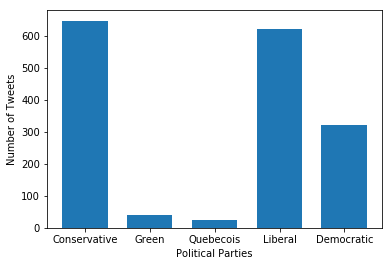

In [10]:
%matplotlib inline
party_labels, party_values = zip(*tweet_parties.items())

tweet_plot = plt.bar(np.arange(len(party_labels)), party_values, 0.7)
plt.xticks(np.arange(len(party_labels)) + 1 * 0.005, party_labels)
plt.ylabel('Number of Tweets')
plt.xlabel('Political Parties')
plt.show()

By plotting the number of tweets related to each party, we see that Conservative and Liberal party gain most attention among all polical parties.

### b. Exploratory Analysis on Classfied Tweets

To analyze in which time part of a day people are more likely to post tweets, we want count the number of tweets that were published in the morning, afternoon and evening.

In [11]:
tweet_times = Counter()
time_parts = {'morning', 'afternoon', 'evening'}

for time in classified_tweetsFrame.loc[:, 'date']:
    time = time.replace('pdt','')
    #get date and time of each tweet, count it toward the tweet_times counter
    datetime_object = datetime.strptime(time, '%a %b %d %H:%M:%S %Y')
    if datetime_object.hour >=16 and datetime_object.hour < 24:
        tweet_times['evening'] += 1
    elif datetime_object.hour >= 0 and datetime_object.hour < 12:
        tweet_times['morning'] += 1
    else:
        tweet_times['afternoon'] += 1
tweet_times     

Counter({'afternoon': 9719, 'evening': 57483, 'morning': 132798})

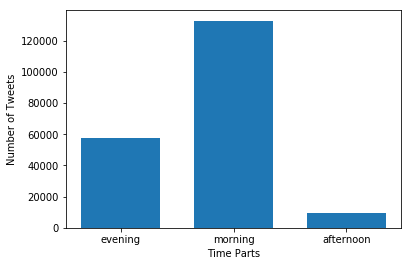

In [12]:
%matplotlib inline
time_labels, time_values = zip(*tweet_times.items())
time_plot = plt.bar(np.arange(len(time_parts)), time_values, 0.7)
plt.xticks(np.arange(len(time_parts)) + 0.7 * 0.005, time_labels)
plt.ylabel('Number of Tweets')
plt.xlabel('Time Parts')
plt.show()

From above analysis, we conclude that most tweets were publish in the morning and evening.

** BONUS ** : Analyze number of tweets published on each of the weekdays

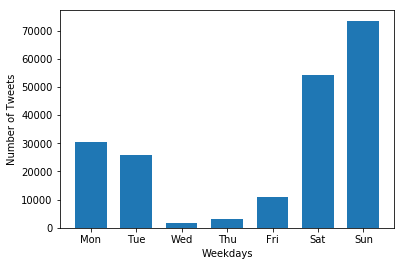

In [13]:
#BONUS
tweet_weekdays = Counter()
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for time in classified_tweetsFrame.loc[:, 'date']:
    time = time.replace('pdt','')
    #get date and time of each tweets
    datetime_object = datetime.strptime(time, '%a %b %d %H:%M:%S %Y')
    tweet_weekdays[weekdays[datetime_object.weekday()]] += 1    

%matplotlib inline
weekday_values = [tweet_weekdays[day] for day in weekdays]
time_plot = plt.bar(np.arange(len(weekdays)), weekday_values, 0.7)
plt.xticks(np.arange(len(weekdays)) + 0.7 * 0.005, weekdays)
plt.ylabel('Number of Tweets')
plt.xlabel('Weekdays')
plt.show()

We can see that most of the tweets were published at the beginning and the end of a week.

## Part 3: Model Preparation

For this section, we first import the classification model libraries that we will use.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
try:
    from sklearn.model_selection import train_test_split
except:
    from sklearn.cross_validation import train_test_split
try:
    from sklearn.model_selection import GridSearchCV
except:
    from sklearn.grid_search import GridSearchCV

Split the classified data randomly into training data (70%) and test data (30%).
X are the tweets, y are the corresponding sentiment values.

In [15]:
X = classified_tweetsFrame.drop(['class'], axis=1)
y = classified_tweetsFrame['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

Use the frequency of each word as the features of the model. We also remove stop words in tweets that are in sklearn english stop word collection.

In [16]:
#count the frequency using CountVectorizer
vectorize = CountVectorizer(stop_words = 'english')
X_vectorized_train = vectorize.fit_transform(X_train['text'])
X_vectorized_test = vectorize.transform(X_test['text'])

## Part 4: Model Implementation

To implement the model, we first train a logistic regression model on the training data and apply the model to the train data and test data to obtain accuracy values.

In [17]:
#initlize logistic regression
lr = LogisticRegression()

#fir lr to training data
lr.fit(X_vectorized_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
# Predict using model
training_predict = lr.predict(X_vectorized_train)
testing_predict = lr.predict(X_vectorized_test)

Training accuracy

In [19]:
df_lg_train_acc = accuracy_score(y_train,training_predict)
df_lg_train_acc

0.8413357142857143

Testing accuracy

In [20]:
df_lg_test_acc = accuracy_score(y_test,testing_predict)
df_lg_test_acc

0.7648666666666667

** BONUS ** : We want to improve the performance of this logistic regression model by tuning its hyperparameter.

We find the corresponding accuracy value of each c parameter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [21]:
#BONUS
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
output_table = pd.DataFrame(columns = ['C_parameter','Testing Accuracy', 'Training Accuracy'])
output_table['C_parameter'] = C

j = 0
for i in C:
    
    #Apply logistic regression model to training data
    lr = LogisticRegression(penalty = 'l2', C = i,random_state = 0)
    lr.fit(X_vectorized_train,y_train)
    
    #Predict sentiment values of training and testing data
    training_predict = lr.predict(X_vectorized_train)
    testing_predict = lr.predict(X_vectorized_test)
    
    #Store accuracy scores in table
    output_table.iloc[j,1] = accuracy_score(y_test,testing_predict)
    output_table.iloc[j,2] = accuracy_score(y_train,training_predict)
    j += 1

   C_parameter Testing Accuracy Training Accuracy
0        0.001           0.7225          0.725536
1        0.010          0.74705          0.755807
2        0.100         0.765767          0.790493
3        1.000         0.764867          0.841336
4       10.000         0.748467          0.883957
5      100.000         0.732333          0.890029
6     1000.000         0.721367          0.890336


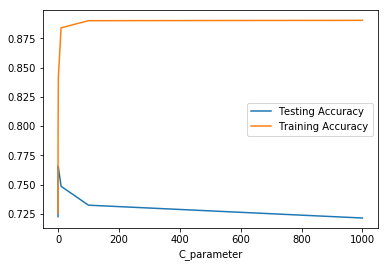

In [22]:
print(output_table)
output_table.plot(x = 'C_parameter')

** BONUS ** : We can also use grid search to find out the best c parameter for our model.

In [23]:
#BONUS
lr = LogisticRegression(random_state=0, penalty='l2')
parameters = {'C': C}

#Use classification accuracy to compare c parameters
acc_scorer_lg = make_scorer(accuracy_score)

#Run a grid search on all the selected parameters
grid_obj_lg = GridSearchCV(lr, parameters, scoring=acc_scorer_lg)
grid_obj_lg = grid_obj_lg.fit(X_vectorized_train, y_train)

#Set our classifier to have the best combination of parameters
lr = grid_obj_lg.best_estimator_

#Fit the selected classifier to the training data. 
lr.fit(X_vectorized_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training accuracy of this model

In [24]:
training_predict = lr.predict(X_vectorized_train)
gs_lg_train_acc = accuracy_score(y_train, training_predict)
gs_lg_train_acc

0.7904928571428571

Testing accuracy of this model

In [25]:
testing_predict = lr.predict(X_vectorized_test)
gs_lg_test_acc = accuracy_score(y_test, testing_predict)
gs_lg_test_acc

0.7657666666666667

Now we have the best c parameter, we can evaluate the model with the unclassified data. 

In [26]:
unclassified_vectorized_test = vectorize.transform(unclassified_tweetsFrame['text'])

#predict sentiment value of unclassfied dataset
unclassfied_predict = lr.predict(unclassified_vectorized_test)

In [27]:
#add ouput of the logistic regression model to unclassfied_tweetsFrame table
unclassified_tweetsFrame['class'] = unclassfied_predict
unclassified_tweetsFrame.head()

,Bloc Quebecois,Conservative,Democratic,Green,Liberal,class,text,tokenized_text
0,false,false,true,false,false,0,﻿living dream cameraman camera cameraception c...,"[﻿living, dream, cameraman, camera, cameracept..."
1,false,false,false,false,true,4,justin trudeau reasons thanksgiving today mont...,"[justin, trudeau, reasons, thanksgiving, today..."
2,false,false,false,false,false,0,themadape butt butt we’re allergic latex makes...,"[themadape, butt, butt, we, ’, re, allergic, l..."
3,false,false,false,false,false,0,2 massive explosions peace march turkey 30 kil...,"[2, massive, explosions, peace, march, turkey,..."
4,false,false,true,false,true,0,mulcair suggests there’s bad blood trudeau rea...,"[mulcair, suggests, there, ’, s, bad, blood, t..."


** BONUS **: Explore multinomial Naive Bayes classifier and compare it with logistic regression model.

In [28]:
#BONUS

#import naive bayes library
from sklearn.naive_bayes import MultinomialNB

#initialize multinomial naive bayes classfifier
nb = MultinomialNB()

# Fit the nb classifier to the training data
nb.fit(X_vectorized_train, y_train)

nb_train_predict = nb.predict(X_vectorized_train)
nb_test_predict = nb.predict(X_vectorized_test)

Training Accuracy

In [29]:
df_nb_train_acc =accuracy_score(y_train, nb_train_predict)
df_nb_train_acc

0.8245214285714285

Testing Accuracy

In [30]:
df_nb_test_acc = accuracy_score(y_test, nb_test_predict)
df_nb_test_acc

0.75645

In [31]:
model_accuracies = pd.DataFrame(columns = [
'Data',
'Default Logistic Regression Accuracy', 
'Grid Search Logistic Regression Accuracy' ,
'Default Naive Bayes Accuracy'])
model_accuracies['Data'] = ['Training', 'Testing']
model_accuracies['Default Logistic Regression Accuracy'] = [df_lg_train_acc, df_lg_test_acc]
model_accuracies['Grid Search Logistic Regression Accuracy'] = [gs_lg_train_acc, gs_lg_test_acc]
model_accuracies['Default Naive Bayes Accuracy'] = [df_nb_train_acc, df_nb_test_acc]

model_accuracies

,Data,Default Logistic Regression Accuracy,Grid Search Logistic Regression Accuracy,Default Naive Bayes Accuracy
0,Training,0.841336,0.790493,0.824521
1,Testing,0.764867,0.765767,0.756450


The accuracies of default multinominal naive bayes classifier model are slightly lower than those of the default logistic regression model.

## Part 5: Discussion

Now as we have the sentiment values and related political parties information of all the tweets in unclassfied dataset, we can count the number of positive and negative tweets of each political parties

This section uses the output of logistic regression with grid search method in part 4.

In [32]:
#count the number of positive and negative tweets for each political parties
political_sentiment = {party:{'positive':0, 'negative':0} for party in parties}
sentiment = unclassified_tweetsFrame['class']
liberal = unclassified_tweetsFrame['Liberal']
conservative = unclassified_tweetsFrame['Conservative']
quebecois = unclassified_tweetsFrame['Bloc Quebecois']
democratic = unclassified_tweetsFrame['Democratic']
green = unclassified_tweetsFrame['Green']

political_sentiment['Liberal']['negative'] = len(unclassified_tweetsFrame[np.logical_and(sentiment == '0', liberal == 'true')])
political_sentiment['Liberal']['positive'] = len(unclassified_tweetsFrame[np.logical_and(sentiment == '4', liberal == 'true')])

political_sentiment['Conservative']['negative'] = len(unclassified_tweetsFrame[np.logical_and(sentiment == '0', conservative == 'true')])
political_sentiment['Conservative']['positive'] = len(unclassified_tweetsFrame[np.logical_and(sentiment == '4', conservative == 'true')])

political_sentiment['Quebecois']['negative'] = len(unclassified_tweetsFrame[np.logical_and(sentiment == '0', quebecois == 'true')])
political_sentiment['Quebecois']['positive'] = len(unclassified_tweetsFrame[np.logical_and(sentiment == '4', quebecois == 'true')])

political_sentiment['Democratic']['negative'] = len(unclassified_tweetsFrame[np.logical_and(sentiment == '0', democratic == 'true')])
political_sentiment['Democratic']['positive'] = len(unclassified_tweetsFrame[np.logical_and(sentiment == '4', democratic == 'true')])

political_sentiment['Green']['negative'] = len(unclassified_tweetsFrame[np.logical_and(sentiment == '0', green == 'true')])
political_sentiment['Green']['positive'] = len(unclassified_tweetsFrame[np.logical_and(sentiment == '4', green == 'true')])

political_sentiment

{'Conservative': {'negative': 211, 'positive': 437},
 'Democratic': {'negative': 70, 'positive': 251},
 'Green': {'negative': 7, 'positive': 33},
 'Liberal': {'negative': 154, 'positive': 468},
 'Quebecois': {'negative': 2, 'positive': 23}}

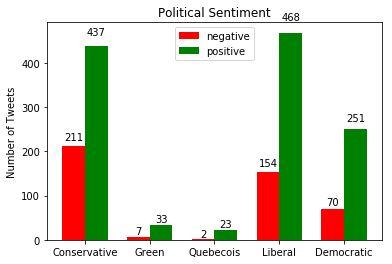

In [33]:
%matplotlib inline
negative = [political_sentiment[party]['negative'] for party in political_sentiment]
positive = [political_sentiment[party]['positive'] for party in political_sentiment]

N = 5
ind = np.arange(N)  #the x locations for the parties
width = 0.35       #the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(ind, negative, width, color='r')
bars2 = ax.bar(ind + width, positive, width, color='g')

#add labels, title and axes ticks
ax.set_ylabel('Number of Tweets')
ax.set_title('Political Sentiment')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels([party for party in political_sentiment])

ax.legend((bars1[0], bars2[0]), ('negative', 'positive'))


def label_bars(bars):
    #label number of tweets for each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 1.05*height,'%d' % int(height), ha='center', va='bottom')

label_bars(bars1)
label_bars(bars2)


plt.show()

From the plot above, we could see that there are lots of tweets related to Liberal and Conservative parties, implying people pay most attention to them. We also see that people pay least attention to Bloc Quebecois and Green party. The number of tweets related to Conservate > Liberal > New NDemocratic > Green > Bloc Quebecois.
 
We could consider the number of positive tweets of each party as number of votes. The potential sequence of number of votes in decreasing order is "Liberal > Conservative > New Democratic > Green > Bloc Quebecois". This is mostly true because the actual result of 2015 Canadian election was "Liberal > Conservative > New Democratic > Bloc Quebecois > Green". We see that Liberal party gains most votes among all parties 

On the other hand, the sequence of number of negative tweets in decreasing order is "Conservative > Liberal > New Democratic > Green > Quebecois". These numbers only reflect the social and political presence of the parties. They do not reveal the support rates of the parties. 